In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment
from src.runner import runner
from src.helpers import confidence_interval, what_informality
import pickle
from sklearn import preprocessing
import random
import json
from matplotlib.dates import DateFormatter
import datetime

In [52]:
style.use('seaborn-white')

### 1 load general the parameters

In [83]:
with open('parameters/parameters.json') as json_file:
    parameters = json.load(json_file)

parameters['data_output'] = 'csv_light'
parameters['number_of_agents'] = 100000

In [84]:
parameters['number_of_agents']

100000

In [85]:
initial_agents = max(round((310 / (3740026 / parameters['number_of_agents']) * 100/14)), 20) # 310 cases / (population / agent) * 1 / 14% detected cases
initial_agents

59

In [86]:
parameters['lockdown_days'] = [x for x in range(0, parameters['time'])]
parameters['total_initial_infections'] = [x for x in range(initial_agents)]

In [87]:
#parameters

In [88]:
parameters['probability_transmission']

0.00335

### 2 load neighbourhood data

In [89]:
with open('parameters/district_data_100k.json') as json_file:
    neighbourhood_data = json.load(json_file)

### Run 3 scenarios:

Lockdown regulation changes: 


* From 1 May level 4
* From 1 June level 3


1. No intervention
2. Formal lockdown
3. Informal lockdown 

First, initialise via pickle 

In [148]:
data = open('seed_22_forjoeri.pkl', "rb")
list_of_objects = pickle.load(data)
environment_base = list_of_objects[0]

data = open('seed_22_forjoeri.pkl', "rb")
list_of_objects = pickle.load(data)
environment_formal = list_of_objects[0]

data = open('seed_22_forjoeri.pkl', "rb")
list_of_objects = pickle.load(data)
environment_informal = list_of_objects[0]

scenarios = ['baseline', 'formal_lockdown', 'informal_lockdown']
environments = [environment_base, environment_formal, environment_informal]

Correct parameters from pickle. 

In [149]:
for env in environments: 
    env.parameters['time'] = parameters['time']
    env.parameters['probability_transmission']= parameters['probability_transmission']#!!!!###!!!###
    env.parameters['number_of_agents'] = 100000 #!!!!###!!!###
    env.parameters['data_output']=parameters['data_output']#!!!!###!!!###
    env.parameters["total_initial_infections"]=parameters["total_initial_infections"]
    env.parameters['informality_dummy']=parameters["informality_dummy"] 
    env.parameters["lockdown_days"]  = parameters["lockdown_days"] 
    env.parameters["health_system_capacity"] =parameters["health_system_capacity"]
    env.parameters['total_initial_infections'] = parameters['total_initial_infections']
    
    # ADD NEW PARAMETER
    env.parameters["perc_infections_detects"] = 1.0#parameters['perc_infections_detects']
    # ADD NEWLY DETECTED CASES
    env.newly_detected_cases = [0 for x in range(parameters['time'])]
    
    # CHANGE POLICY PARAMETERS
    env.parameters["physical_distancing_multiplier"] = 0.91# 0.51
    env.parameters["visiting_recurring_contacts_multiplier"] = 0.5387393162393163 #0.5387393162393163
    env.parameters["likelihood_awareness"] = 0.1 # 0.54
    env.parameters["gathering_max_contacts"] = 32# 12

In [150]:
data_folder = 'measurement/baseline_100k/'
seed = 22

In [151]:
for env, sc in zip(environments, scenarios):
    if sc == 'baseline':
        env.parameters["lockdown_days"] = [0 for x in parameters["lockdown_days"]]
    if sc == 'formal_lockdown':
        env.parameters['informality_dummy'] = 0.0
    
    if sc == 'informal_lockdown':
        env.parameters['informality_dummy'] = 1.0
    
    if env.parameters['informality_dummy'] == 1.0:
        for agent in env.agents:
            agent.informality = what_informality(agent.district, neighbourhood_data) * parameters["informality_dummy"]
        
    env = runner(env, 0, data_folder=data_folder, data_output=env.parameters['data_output'])
    
    if parameters["data_output"] == 'csv_light':
        pd.DataFrame(env.infection_quantities).to_csv('{}seed{}/quantities_state_time_{}.csv'.format(data_folder,
                                                                                                      seed, sc))

31
7
6


In [152]:
environments[2].parameters['informality_dummy']

1.0

In [153]:
scenarios[2]

'informal_lockdown'

### Analyse data for the three scenarios

In [154]:
data_scenarios = [pd.read_csv('{}seed{}/quantities_state_time_{}.csv'.format(data_folder, seed, sc), index_col=0) for sc in scenarios]

In [155]:
start_date = datetime.datetime(2020, 3, 29)
dates = [start_date + datetime.timedelta(days=x) for x in data_scenarios[0].index]

In [156]:
multiplication_factor = 37.40026
detection_m_factor = multiplication_factor * 0.14

### Compare to the actual case numbers for cape town:

In [157]:
detected_cases = pd.read_csv('input_data/detected_cases_cape_town_metro.csv')['Cases']
#tests_conducted = pd.read_csv('input_data/detected_cases_cape_town_metro.csv')['Cases']
#detected_cases.plot()

In [165]:
# 14 * x = 100 
# x = 100/14
detected_cases * 100/14

0       2214.285714
1               NaN
2       2485.714286
3       2642.857143
4       2807.142857
5       2985.714286
6       3185.714286
7       3314.285714
8       3392.857143
9       3500.000000
10      3642.857143
11      3728.571429
12      3892.857143
13      4050.000000
14      3992.857143
15      4485.714286
16      4692.857143
17      4828.571429
18      5014.285714
19      5307.142857
20      5800.000000
21      6185.714286
22      6464.285714
23      6957.142857
24      7628.571429
25      8235.714286
26      9385.714286
27     10250.000000
28     10935.714286
29     11557.142857
          ...      
48     60764.285714
49     66042.857143
50     70907.142857
51     75414.285714
52     79085.714286
53     84357.142857
54     89421.428571
55     92478.571429
56     99778.571429
57    106985.714286
58    112542.857143
59    118221.428571
60    123471.428571
61    131071.428571
62    139000.000000
63    150735.714286
64    157764.285714
65    164964.285714
66    175457.142857


Text(0.5, 0, 'Date')

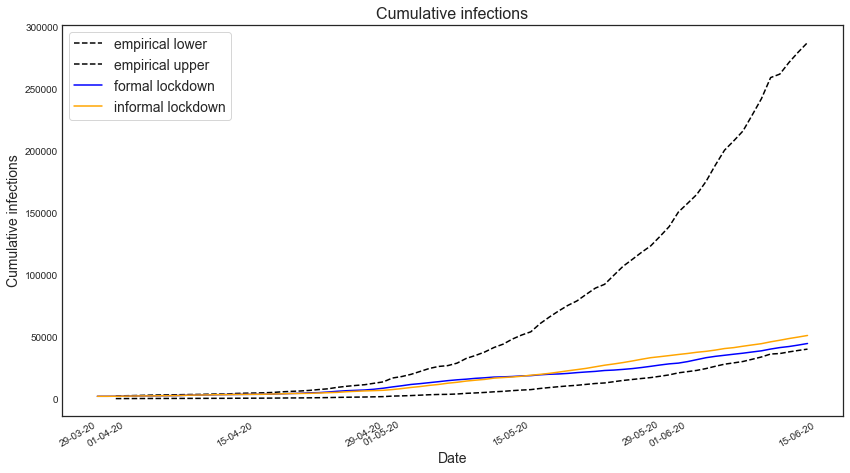

In [172]:
fig, ax = plt.subplots(figsize=(14,8))

ax.set_title('Cumulative infections', fontsize='16')

ax.plot(dates, detected_cases, 'k--', label='empirical lower')

ax.plot(dates, detected_cases * 100/14, 'k--', label='empirical upper')


#ax.plot(dates, (data_scenarios[0]['e'] + data_scenarios[0]['i1'] + data_scenarios[0]['i2']) * multiplication_factor, label='baseline')
# ax.plot(dates, (data_scenarios[0]['detected'].cumsum() * multiplication_factor), label='baseline', 
#         color='red', linestyle='-')

#ax.plot(dates, (data_scenarios[1]['e'] + data_scenarios[1]['i1'] + data_scenarios[1]['i2']) * multiplication_factor, label='formal')
ax.plot(dates, (data_scenarios[1]['detected'].cumsum() * multiplication_factor), label='formal lockdown', 
        color='blue', linestyle='-')


#ax.plot(dates, (data_scenarios[2]['e']  + data_scenarios[2]['i1'] + data_scenarios[2]['i2']) * multiplication_factor, label='informal')
ax.plot(dates, (data_scenarios[2]['detected'].cumsum() * multiplication_factor), label='informal lockdown', 
        color='orange', linestyle='-')

myFmt = DateFormatter("%d-%m-%y")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()


ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cumulative infections', fontsize='14')
ax.set_xlabel('Date', fontsize='14')